# Real distributions vs Permutation

As we have seen, most tricksters exist where corresponding real animals are observed. 
However, because of cultural transmission, distribusions are more dense in realized tricksters distributions than a null hypothesis (trcikster randomly distributed where real animals are observed).

To avoid the problems of difference in research efforts, we only consider presence/absence in each hex grid.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import sys
import latlon_utils 
#import rioxarray as rxr  we used this function to read tiff, but could cause conflict with plotting hex grids
import h3
from geopy.distance import geodesic
#from geojson import Feature, Point, FeatureCollection, Polygon
import plotly.express as px
import random
import scipy as sp
from scipy.integrate import cumtrapz
import statsmodels
from statsmodels.stats import multitest
import math
#import statannot
df=pd.read_csv('TrickSter_data3.csv')
df

,nid,lat,lng,TrickSter,Annu_Mean_Temp,Annu_Prec,hex_index,presence,Norm_Annu_Mean_Temp,Norm_Annu_Prec
0,103918,68.72000,158.70000,raven,-13.231120,173.0,8104fffffffffff,1,0.050405,0.025701
1,103817,64.95187,64.64844,raven,-4.123444,473.0,81107ffffffffff,1,0.249975,0.072716
2,3926,57.82907,-152.98389,raven,3.271220,1499.0,810c7ffffffffff,1,0.412010,0.233506
3,2434,51.00000,-112.50000,raven,3.957418,342.0,8112fffffffffff,1,0.427046,0.052186
4,2439,40.00000,-103.00000,raven,9.747086,395.0,8126bffffffffff,1,0.553911,0.060492
...,...,...,...,...,...,...,...,...,...,...
512,2464,52.00000,-120.00000,wren,1.460037,964.0,8112fffffffffff,1,0.372323,0.149663
513,2466,50.50000,-122.80000,wren,4.090998,822.0,8128fffffffffff,1,0.429973,0.127409
514,2472,47.11975,-123.53846,wren,9.940903,1873.0,8128fffffffffff,1,0.558158,0.292117
515,2477,45.50000,-124.00000,wren,10.183416,2005.0,8128fffffffffff,1,0.563472,0.312804


In [2]:
print("Python Current Version:-", sys.version)
# some critical packages
print("H3 package version:-", h3.__version__)
print("Statsmodels package version:-", statsmodels.__version__)
print("Latlon package version:-", latlon_utils.__version__) # retrive data from World clim
# other used packages
print("Numpy package version:-", np.__version__)
print("Scipy package version:-", sp.__version__)
print("Pandas package version:-", pd.__version__)
print("Geopandas package version:-", gpd.__version__)

Python Current Version:- 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]
H3 package version:- 3.7.6
Statsmodels package version:- 0.13.5
Latlon package version:- 0.0.7
Numpy package version:- 1.23.5
Scipy package version:- 1.10.0
Pandas package version:- 1.5.3
Geopandas package version:- 0.9.0


In [2]:
def MedianDistance(data):
    # calculate median distance given data points
    center_lng=[]
    center_lat=[]
    for i in range(len(data)):
        x=h3.h3_to_geo_boundary(data[i], True)
        x=np.mean(x, axis=0)
        center_lng.append(x[0])
        center_lat.append(x[1])
    df=pd.DataFrame({'latitude':center_lat, 'longitude':center_lng})
    Distance=[] # realized distances between tricksters
    for i in range(len(df)):
        place1=df.iloc[i, :]
        for j in range(i+1, len(df)):
            place2=df.iloc[j, :]
            Distance.append(geodesic(place1, place2).km)
    return np.median(Distance)

def Distribution_Test(df, target, rep=10000):
    # Test whether TS is more dense than random distributions on RA
    # df: data farme of tricksters. See above as an example
    # target: str of target species
    # rep: int of replications to generate a median distributions under the null hypothesis
    if target == 'water bird' or target == "monkey" or target == 'ground_squirrel':
        print ("We ignore this species")
        return np.nan
    else:
        #---------------------------------------------------------------------------------------------
        # Step　1: calculate distances between tricksters
        hex_TS=np.unique(df[df['TrickSter']==target]['hex_index']) # hex_grids of focal Tricksters
        median_TS=MedianDistance(hex_TS)
        #---------------------------------------------------------------------------------------------
        # Step　2: calculate distances under null hypothesis (random distirbutions of TS given RA exist)
        df_meta=pd.read_csv('./GBIF/For_gbif_trickstar.xlsx - Sheet1.csv') # meta file
        taxa=df_meta[df_meta['Category']==target]['Taxa'].reset_index(drop=True)
        for i in range(len(taxa)):
            if i==0:
                data=pd.read_csv('./GBIF/'+target+'/'+taxa[i]+'_cleaned.csv')
            else:
                dd=pd.read_csv('./GBIF/'+target+'/'+taxa[i]+'_cleaned.csv')
                data=pd.concat([data,dd])
        #print(data)
        hex_RA=np.unique(data['hex_index'])
        Median_RA=[]
        for k in range(rep):
            hex_extract=np.random.choice(hex_RA, len(hex_TS), replace=False)
            Median_RA.append(MedianDistance(hex_extract))
        kernel=sp.stats.gaussian_kde(Median_RA)
        x=np.linspace(0, max(Median_RA), 5000)
        y=kernel(x)
        cum_y= cumtrapz(y, x)
        idx_d= np.searchsorted(cum_y, 0.05) # index of x that gives cum~0.0.5
        p_val= cum_y[np.searchsorted(x, median_TS, side='right')]
        plt.plot(x, y, color='#66c2a5')
        plt.vlines(x=median_TS, ymin=0, ymax=max(y)*0.8, color='k', linestyle='--')
        plt.ylim(0, max(y)*1.05)
        plt.fill_between(x[:idx_d], np.zeros([np.size(x[:idx_d])]), y[:idx_d], color='#66c2a5')
        plt.xlabel("Median distance (km)", fontsize=20)
        plt.xticks([0, 4000, 8000, 12000], fontsize=16)
        plt.ylabel("Probability", fontsize=20)
        plt.yticks(fontsize=16)
        plt.text(x=median_TS*0.9, y=0.8*(max(y)), s='Median of tricksters', fontsize=16)
        plt.title(target, fontsize=28)
        plt.savefig("CompareDistance_Earth"+target+".pdf", bbox_inches='tight', pad_inches=0.05)
        plt.show()
        return p_val # significance

            
            
        
    
            
        
        

0


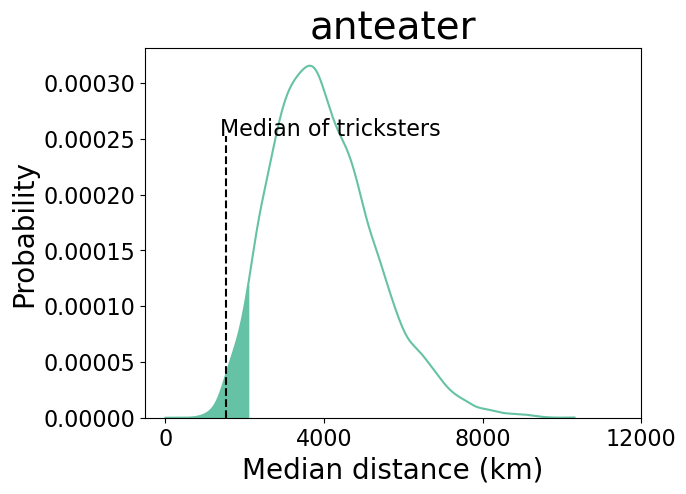

1


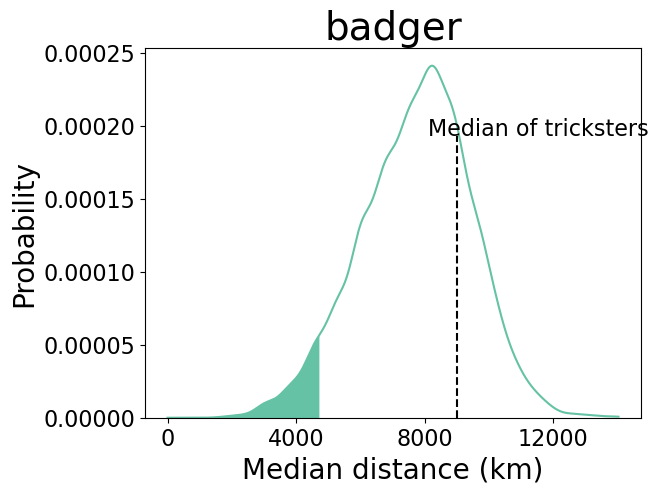

2


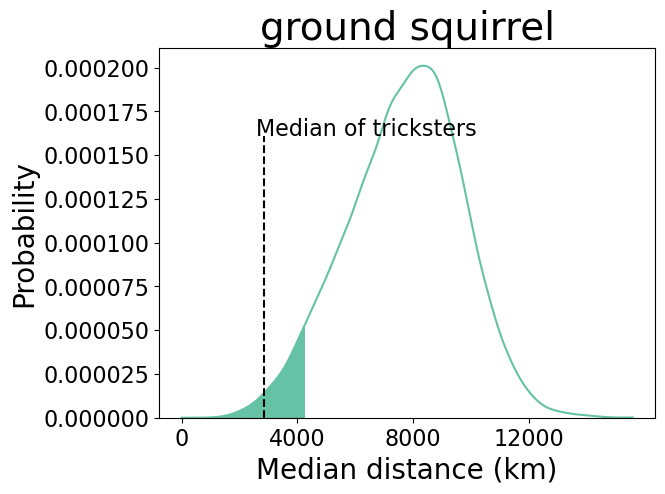

3


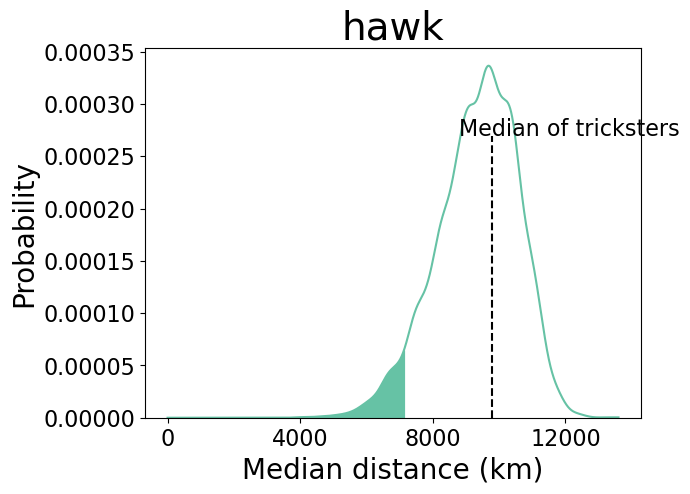

4


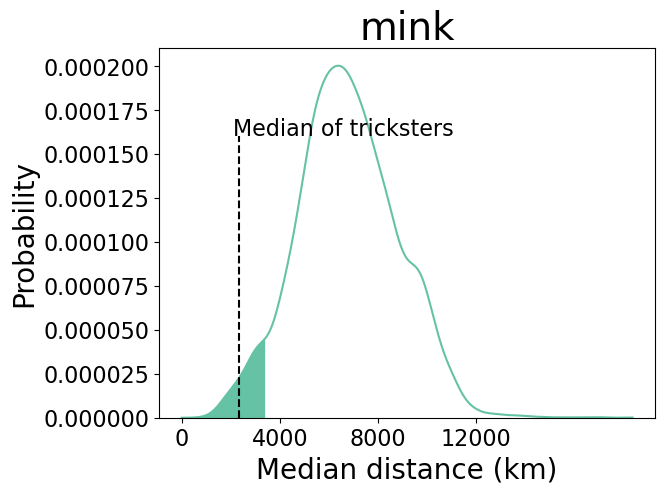

5
We ignore this species
6


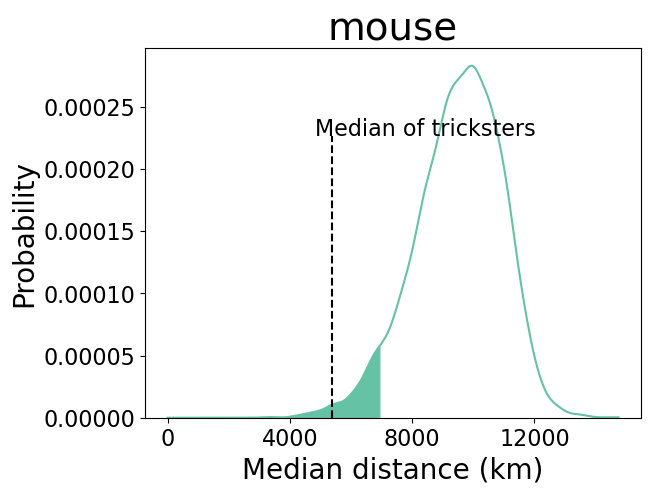

7


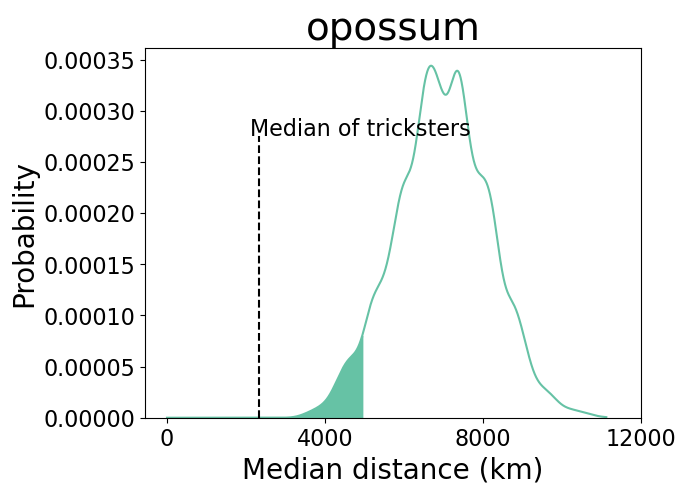

8


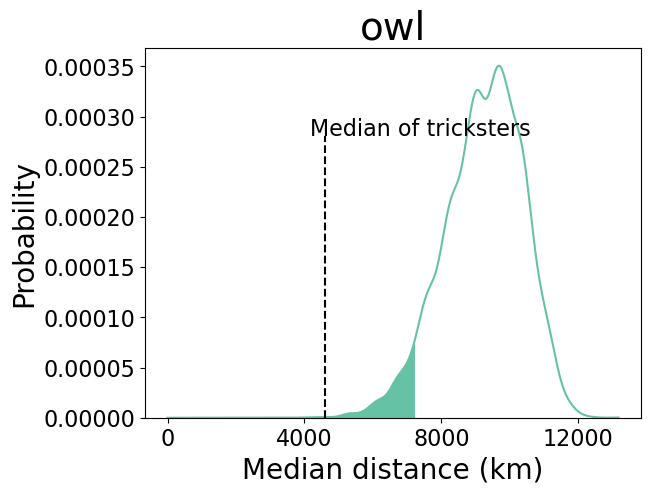

9


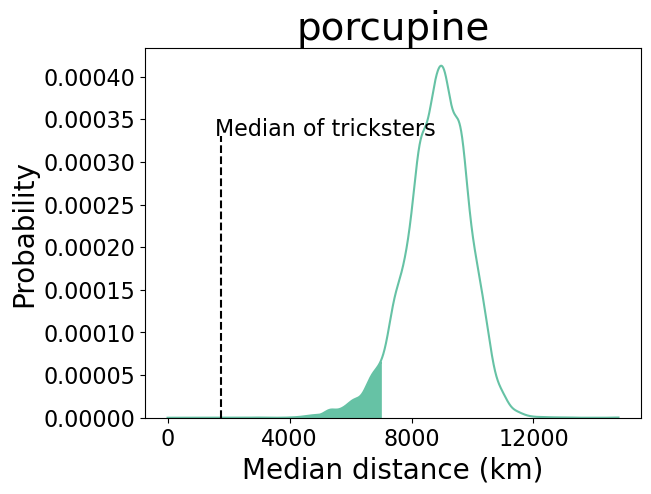

10


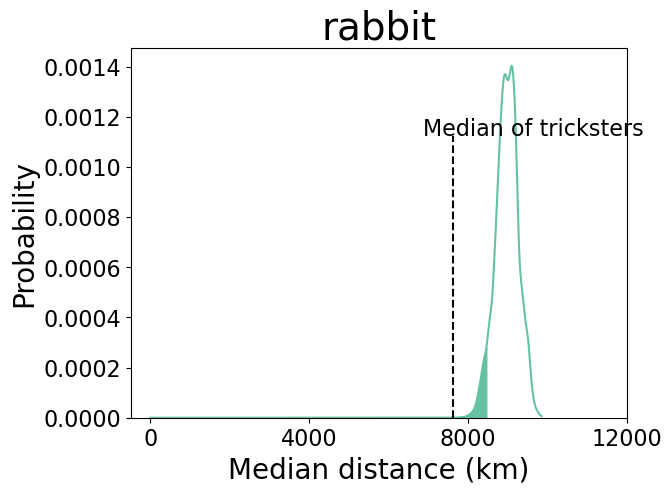

11


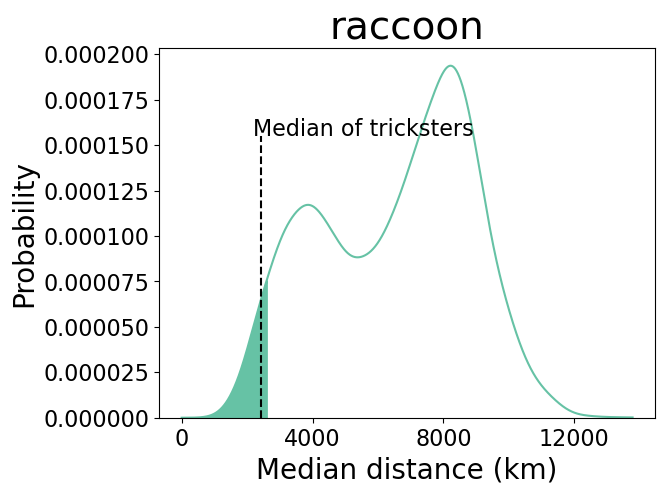

12


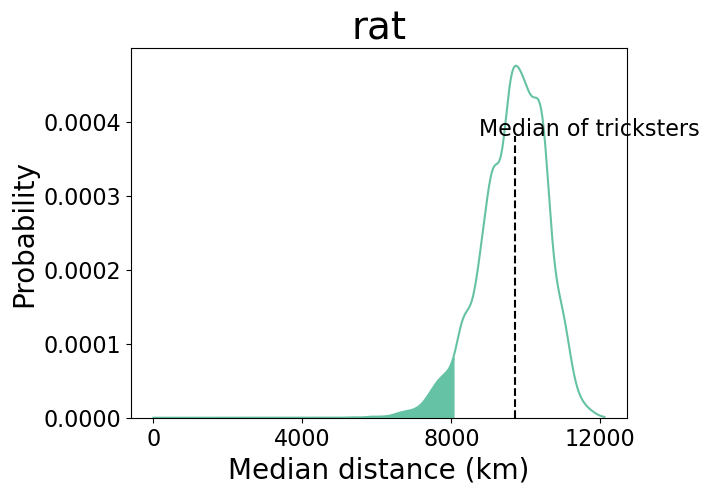

13


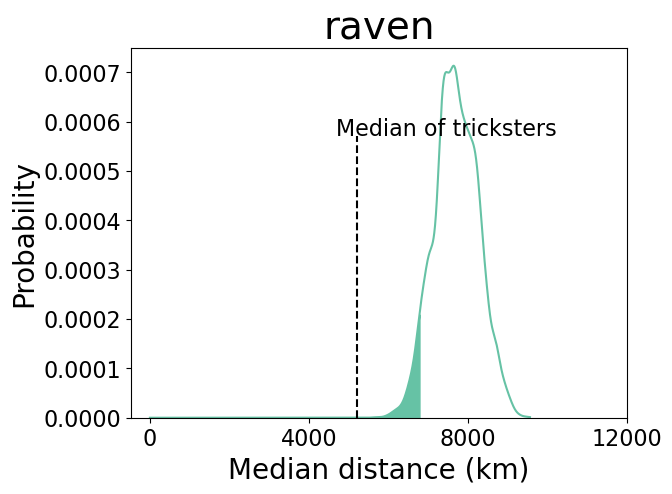

14


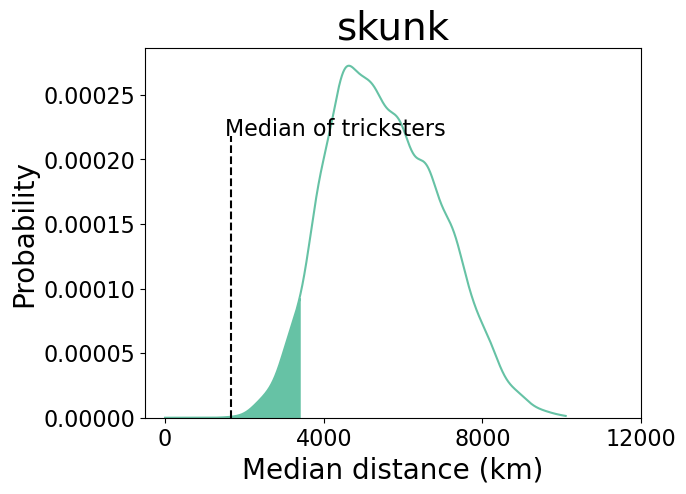

15


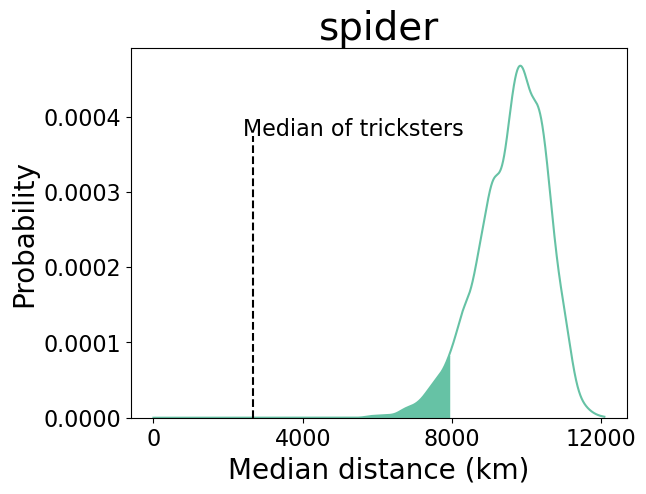

16
We ignore this species
17


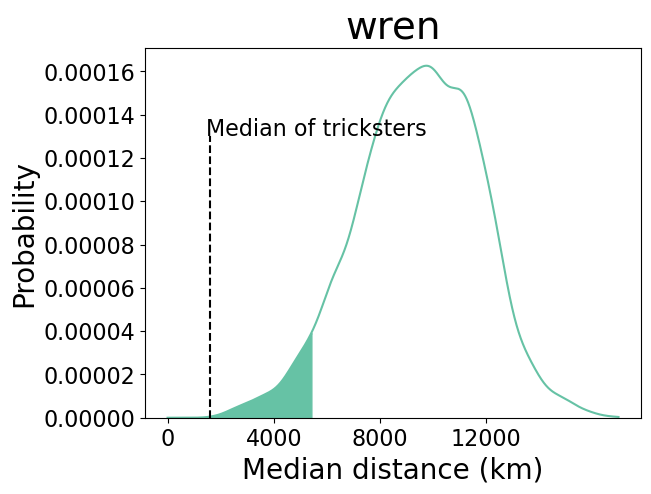

,Tricksters,P values
0,anteater,9.175249e-03
1,badger,7.667480e-01
2,ground squirrel,8.617822e-03
3,hawk,6.091850e-01
4,mink,1.435613e-02
5,monkey,NaN
6,mouse,6.633914e-03
7,opossum,3.893430e-12
8,owl,3.726845e-04
9,porcupine,9.084544e-17


In [3]:
species=np.sort(np.unique(df["TrickSter"]))
P_vals=[]
for i in range(len(species)):
    target=species[i]
    print(i)
    P_vals.append(Distribution_Test(df, target, rep=10000))
    
df_result=pd.DataFrame({'Tricksters':species, 'P values':P_vals})     
df_result

In [4]:
df_result=pd.DataFrame({'Tricksters':species, 'P values':P_vals})    
df_result=df_result.drop(index=[5, 16])

In [5]:
# need to remove monkey bird and GS

a, b=multitest.fdrcorrection(df_result['P values'])
df_result['FDR']=a
df_result

,Tricksters,P values,FDR
0,anteater,9.175249e-03,True
1,badger,7.667480e-01,False
2,ground squirrel,8.617822e-03,True
3,hawk,6.091850e-01,False
4,mink,1.435613e-02,True
6,mouse,6.633914e-03,True
7,opossum,3.893430e-12,True
8,owl,3.726845e-04,True
9,porcupine,9.084544e-17,True
10,rabbit,7.392047e-05,True


In [7]:
13/16

0.8125

Mote that the pvalues  may sligtly differ from the manuscript due to the stochasticity of the permutation analysis.

As we can see above, about 80% data (where we remove three species from the analysis) suggest that TS is more clugged than the null hypothsis. The exceptions are badger, hawk, racoonm, and rat. RA distribution of racoon is clugged while that of badger hawk, and rat are as broad as those of TS, respectively (see Analysis Note 6). In the above figures, these three species show median >8000km